## Trabajo Fin de Máster <br/> Diseño de una arquitectura multimodal para descripción textual de pares imagen-audio

## Script 7. Detección de caras en una imagen y aplicación del modelo completo

En este notebook, hacemos uso de la librería FaceNet para detectar las caras que hay en una imagen con varias personas, y posteriormente aplicamos el modelo obtenido en el notebook 6 para discernir quién es dentro de nuestra base de datos.

### Paso 1. Montamos el almacenamiento

Damos permiso a Colab para acceder a mi unidad de Drive y nos situamos en la carpeta donde tenemos los scripts y la librería que hemos creado con las clases propias.

In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0)

In [2]:
import os
os.chdir('..')
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/tfm-cpu/code/Users/jose.puche/Scripts'

### Paso 2. Definición de parámetros y configuración

In [3]:
import clip
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset, SubsetRandomSampler, DataLoader

from IPython.display import Audio 

from tfm_lib.audio_processing import AudioUtil, AudioAugmentation
from tfm_lib.datasets import CustomDataset
from tfm_lib.modelos import AudioCLIP
from tfm_lib.EarlyStopping import EarlyStopping

/anaconda/envs/jupyter_env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
folder_path = './../Final_Database'
num_epochs = 20
BATCH_SIZE = 16
data_augmentation = True
da = "_DA" if data_augmentation else ""
lr = 1e-4
output_dim = 40
selected_model = 'RN50'

model_parameters_file = f"./modelos/multimodal/FULL_{selected_model.replace('/','')}_{output_dim}pers_lr{f'{lr:.0e}'}_bs{BATCH_SIZE}_{num_epochs}ep{da}.pt"
print("Model:", model_parameters_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = AudioCLIP(selected_model, device, output_dim).to(device)
model.load_state_dict(torch.load(model_parameters_file, map_location=torch.device('cpu')))

Model: ./modelos/multimodal/FULL_RN50_40pers_lr1e-04_bs16_20ep_DA.pt
Device: cpu


<All keys matched successfully>

In [6]:
classes = [ 'Alba Azorin Zafrilla', 'Alfonso Girona Palao', 'Alfonso Vidal Lopez', 'Ana Azorin Puche', 
            'Ana Puche Palao', 'Angela Espinosa Martinez', 'Clara Hidalgo Lopez', 'Cristina Carpena Ortiz',
            'David Azorin Soriano', 'Diego Molina Puche', 'Eva Jimenez Mariscal',
            'Francisco Jose Maldonado Montiel', 'Genesis Reyes Arteaga', 'Irene Gutierrez Perez', 
            'Irene Molina Puche', 'Irene Ponte Ibanez', 'Iria Alonso Alves', 'Javier Lopez Martinez',
            'Jonathan Gonzalez Lopez', 'Jorge Salinas Puche', 'Jose Alberto Azorin Puche', 'Jose Azorin Verdu',
            'Jose Duenas Garcia', 'Jose Manuel Nieto del Valle', 'Joseju Ubric Quesada', 'Juan Cuesta Lopez',
            'Juanjo Bautista Ibanez', 'Lydia Bautista Ibanez', 'Maria Jose Morales Forte', 'Mercedes Parody Guzman',
            'Miguel Correas Perez', 'Nerea Hernandez Carpintero', 'Noelia Sanchez Alonso', 'Oscar del Barrio Farran',
            'Rafael Molina Lopez', 'Regina SanMartino Miralles', 'Rodrigo Soriano Gonzalez', 'Rosi Puche Palao',
            'Sandra Castano Azorin', 'Sergio Castano Azorin']

### Paso 3. Lectura de los datos de prueba

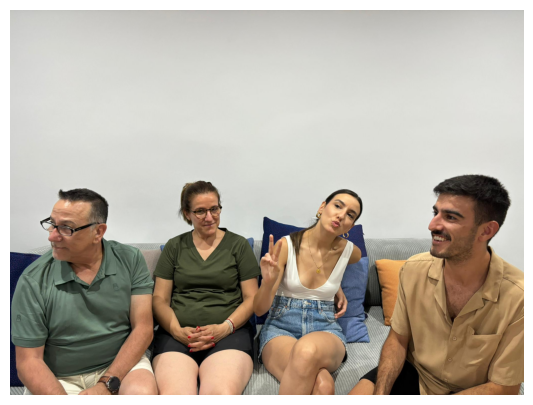

In [7]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

imagen_1 = Image.open('./../Test_images/video_prueba_1/imagen0009.jpeg')

plt.figure(figsize=(7, 5))
plt.imshow(imagen_1)
plt.axis('off');

### Paso 5. Detección de caras con FaceNet

In [8]:
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn_0 = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 224,
            device         = device
        )

Running on device: cpu


In [9]:
boxes, probs, landmarks = mtcnn_0.detect(imagen_1, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[1676.8519287109375 724.1514282226562 1863.145751953125
  980.7471923828125]
 [152.0295867919922 765.9794311523438 332.4726257324219 993.8589477539062]
 [1248.587890625 723.2476806640625 1387.250732421875 897.8385620117188]
 [719.2119140625 733.4689331054688 837.945068359375 890.6934814453125]]
Probability: [0.9999985694885254 0.999640941619873 0.9999818801879883
 0.9999616146087646]
landmarks: [[[1696.4229736328125 814.5188598632812]
  [1761.7164306640625 823.4938354492188]
  [1689.3143310546875 862.4917602539062]
  [1684.171875 916.457763671875]
  [1747.1282958984375 919.9443359375]]

 [[176.21578979492188 868.6542358398438]
  [245.9424285888672 867.3221435546875]
  [186.77218627929688 912.160888671875]
  [183.90615844726562 959.7234497070312]
  [237.666259765625 957.7618408203125]]

 [[1307.0592041015625 782.42236328125]
  [1357.266357421875 816.5894165039062]
  [1321.31298828125 827.4833984375]
  [1276.3531494140625 844.0657348632812]
  [1313.947021484375 869.82543

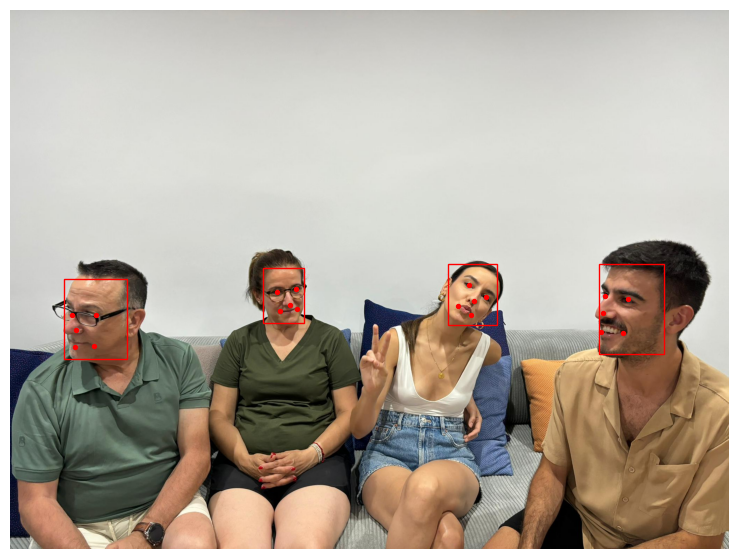

In [10]:
# Representación con matplotlib
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(imagen_1)

for box, landmark in zip(boxes, landmarks):
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
    rect = plt.Rectangle(
                xy     = (box[0], box[1]),
                width  = box[2] - box[0],
                height = box[3] - box[1],
                fill   = False,
                color  = 'red'
           )
    ax.add_patch(rect)

ax.axis('off');

In [13]:
# Detector MTCNN
# ==============================================================================
mtcnn_1 = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 224,
            device        = device
        )

# Detección de caras
# ==============================================================================
faces = mtcnn_1.forward(imagen_1)

faces.shape

torch.Size([4, 3, 224, 224])

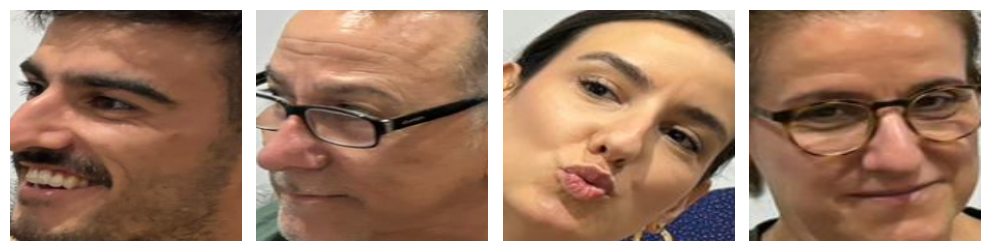

In [14]:
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))
axs= axs.flatten()

for i in range(faces.shape[0]):
    face = faces[i,:,:,:].permute(1, 2, 0).int().numpy()
    axs[i].axis('off')
    axs[i].imshow(face)

plt.tight_layout();

## Prueba con ViT-B/32

In [23]:
import torchvision.transforms as T
transform = T.ToPILImage()
text = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)
data = []

for name in ['Jose Alberto Azorin Puche', 'Jose Azorin Verdu', 'Ana Azorin Puche', 'Ana Puche Palao']:
  aud = AudioUtil.open(f'./../Test_images/audios/{name}.ogg')
  aud = AudioUtil.resample(aud, 16000)
  aud = AudioUtil.rechannel(aud, 1)
  aud = AudioAugmentation.pad_trunc(aud, 4)
  sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None).unsqueeze(0).to(device)

  for i in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']:
    imagen_1 = Image.open(f'./../Test_images/video_prueba_1/imagen00{i}.jpeg')
    faces = mtcnn_1.forward(imagen_1)
    
    for j in range(4):
      read_image = faces[j,:,:,:].type(torch.uint8)
      image = model.preprocess(transform(read_image)).unsqueeze(0).to(device)
      
      with torch.no_grad():
        output = model(image, text, sgram)
        probs = output.softmax(dim=-1)
        pred_prob = torch.max(probs).item()
        pred_person = classes[torch.argmax(probs)]
        data.append({
          'Imagen': f'imagen00{i}.jpeg',
          'Audio': name,
          'Cara': j,
          'Persona': pred_person,
          'Jose Alberto': probs.squeeze()[list(classes).index('Jose Alberto Azorin Puche')].item(),
          'Jose Azorin': probs.squeeze()[list(classes).index('Jose Azorin Verdu')].item(),
          'Ana Puche': probs.squeeze()[list(classes).index('Ana Puche Palao')].item(),
          'Ana Azorin': probs.squeeze()[list(classes).index('Ana Azorin Puche')].item()
        })

#pd.DataFrame(data = {'Persona': classes, 'Probabilidad': output.softmax(dim=-1)[0].tolist()}).sort_values('Probabilidad', ascending=False).head()

resultados = pd.DataFrame(data)

In [49]:
resultados[resultados.Imagen == 'imagen0015.jpeg']

,Imagen,Audio,Cara,Persona,Jose Alberto,Jose Azorin,Ana Puche,Ana Azorin
56,imagen0015.jpeg,Jose Alberto Azorin Puche,0,Jose Alberto Azorin Puche,0.954332,0.000004,0.002474,1.927843e-06
57,imagen0015.jpeg,Jose Alberto Azorin Puche,1,Jose Azorin Verdu,0.000068,0.760212,0.000032,7.465094e-07
58,imagen0015.jpeg,Jose Alberto Azorin Puche,2,Clara Hidalgo Lopez,0.005084,0.048519,0.000144,2.770038e-02
59,imagen0015.jpeg,Jose Alberto Azorin Puche,3,Jose Azorin Verdu,0.000858,0.307763,0.046768,9.782857e-06
116,imagen0015.jpeg,Jose Azorin Verdu,0,Jose Alberto Azorin Puche,0.954332,0.000004,0.002474,1.927843e-06
117,imagen0015.jpeg,Jose Azorin Verdu,1,Jose Azorin Verdu,0.000068,0.760212,0.000032,7.465094e-07
118,imagen0015.jpeg,Jose Azorin Verdu,2,Clara Hidalgo Lopez,0.005084,0.048519,0.000144,2.770038e-02
119,imagen0015.jpeg,Jose Azorin Verdu,3,Jose Azorin Verdu,0.000858,0.307763,0.046768,9.782857e-06
176,imagen0015.jpeg,Ana Azorin Puche,0,Jose Alberto Azorin Puche,0.954332,0.000004,0.002474,1.927843e-06
177,imagen0015.jpeg,Ana Azorin Puche,1,Jose Azorin Verdu,0.000068,0.760212,0.000032,7.465093e-07


In [51]:
vit = 3+2+2+4+2+2+2+2+4+2+3+2+3+4+2
print('Accuracy para ViT:', vit/(15*4))

Accuracy para ViT: 0.65


## Prueba con ResNet-50

In [15]:
import torchvision.transforms as T
transform = T.ToPILImage()
text = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)
data = []

for name in ['Jose Alberto Azorin Puche', 'Jose Azorin Verdu', 'Ana Azorin Puche', 'Ana Puche Palao']:
  aud = AudioUtil.open(f'./../Test_images/audios/{name}.ogg')
  aud = AudioUtil.resample(aud, 16000)
  aud = AudioUtil.rechannel(aud, 1)
  aud = AudioAugmentation.pad_trunc(aud, 4)
  sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None).unsqueeze(0).to(device)

  for i in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']:
    imagen_1 = Image.open(f'./../Test_images/video_prueba_1/imagen00{i}.jpeg')
    faces = mtcnn_1.forward(imagen_1)
    
    for j in range(4):
      read_image = faces[j,:,:,:].type(torch.uint8)
      image = model.preprocess(transform(read_image)).unsqueeze(0).to(device)
      
      with torch.no_grad():
        output = model(image, text, sgram)
        probs = output.softmax(dim=-1)
        pred_prob = torch.max(probs).item()
        pred_person = classes[torch.argmax(probs)]
        data.append({
          'Imagen': f'imagen00{i}.jpeg',
          'Audio': name,
          'Cara': j,
          'Persona': pred_person,
          'Jose Alberto': probs.squeeze()[list(classes).index('Jose Alberto Azorin Puche')].item(),
          'Jose Azorin': probs.squeeze()[list(classes).index('Jose Azorin Verdu')].item(),
          'Ana Puche': probs.squeeze()[list(classes).index('Ana Puche Palao')].item(),
          'Ana Azorin': probs.squeeze()[list(classes).index('Ana Azorin Puche')].item()
        })

#pd.DataFrame(data = {'Persona': classes, 'Probabilidad': output.softmax(dim=-1)[0].tolist()}).sort_values('Probabilidad', ascending=False).head()

resultados = pd.DataFrame(data)

In [30]:
resultados[resultados.Imagen == 'imagen0015.jpeg']

,Imagen,Audio,Cara,Persona,Jose Alberto,Jose Azorin,Ana Puche,Ana Azorin
56,imagen0015.jpeg,Jose Alberto Azorin Puche,0,Jonathan Gonzalez Lopez,0.000463,0.001178,0.194925,0.001809
57,imagen0015.jpeg,Jose Alberto Azorin Puche,1,Ana Puche Palao,0.000019,0.001423,0.492854,0.001779
58,imagen0015.jpeg,Jose Alberto Azorin Puche,2,Jonathan Gonzalez Lopez,0.000373,0.001265,0.240789,0.000698
59,imagen0015.jpeg,Jose Alberto Azorin Puche,3,Jonathan Gonzalez Lopez,0.000159,0.003391,0.245476,0.002195
116,imagen0015.jpeg,Jose Azorin Verdu,0,Jonathan Gonzalez Lopez,0.000463,0.001178,0.194925,0.001809
117,imagen0015.jpeg,Jose Azorin Verdu,1,Ana Puche Palao,0.000019,0.001423,0.492854,0.001779
118,imagen0015.jpeg,Jose Azorin Verdu,2,Jonathan Gonzalez Lopez,0.000373,0.001265,0.240789,0.000698
119,imagen0015.jpeg,Jose Azorin Verdu,3,Jonathan Gonzalez Lopez,0.000159,0.003391,0.245476,0.002195
176,imagen0015.jpeg,Ana Azorin Puche,0,Jonathan Gonzalez Lopez,0.000463,0.001178,0.194925,0.001809
177,imagen0015.jpeg,Ana Azorin Puche,1,Ana Puche Palao,0.000019,0.001423,0.492854,0.001779


In [31]:
vit = 1+1+0+1+1+0+2+1+1+1+1+0+1+0+1
print('Accuracy para RN50:', vit/(15*4))

Accuracy para RN50: 0.2
